In [1]:
import sys
from os import listdir
import os

from xml.dom.minidom import parse

import pandas as pd
import numpy as np

import nltk
from nltk import tokenize

import matplotlib.pyplot as plt

import sklearn
from sklearn import preprocessing


print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The nltk version is 3.2.5.
The scikit-learn version is 0.20.1.


In [2]:
dir_train_medline = "/Users/lluccardoner/PycharmProjects/MET_AHLT_Lab_2019/data/Train/MedLine/"
dir_train_drugbank = "/Users/lluccardoner/PycharmProjects/MET_AHLT_Lab_2019/data/Train/DrugBank/"

In [3]:
dir_test_medline = "/Users/lluccardoner/PycharmProjects/MET_AHLT_Lab_2019/data/Test-NER/MedLine/"
dir_test_drugbank = "/Users/lluccardoner/PycharmProjects/MET_AHLT_Lab_2019/data/Test-NER/DrugBank/"

# Data

In [4]:
def parse_XML_file(datadir):
    trees = []
    for f in listdir(datadir):
        # parse XML file
        tree = parse(datadir + "/" + f)
        trees.append(tree)
    return trees

def parsed_to_df(parsed):
    items = []
    for tree in parsed:
        for s in tree.getElementsByTagName("sentence"):
            s_id = s.attributes["id"].value
            s_txt = s.attributes["text"].value            
            
            e_names = []
            for e in s.getElementsByTagName("entity"):
                e_name = e.attributes["text"].value
                e_type = e.attributes["type"].value
                e_offset = e.attributes["charOffset"].value
                item = {"s_id": s_id, "e_name": e_name, "e_type": e_type, "e_offset": e_offset}
                e_names.append(e_name)
                items.append(item)
                
            tkns = nltk.word_tokenize(s_txt)
            for tkn in tkns:
                if tkn not in e_names: # not robust
                    start = s_txt.find(tkn, start) 
                    end = start + len(tkn) - 1
                    e_offset = str(start)+"-"+str(end)
                    item = {"s_id": s_id, "e_name": tkn, "e_type": "not_drug", "e_offset": e_offset}
                    items.append(item)
                    start += len(tkn)
                
    return pd.DataFrame(items)

def load_data(datadir):
    trees = parse_XML_file(datadir)
    df_loaded = parsed_to_df(trees)
    return df_loaded

## Train Data

In [5]:
df_train_drugbank = load_data(dir_train_drugbank)
df_train_drugbank.shape

(120594, 4)

In [6]:
df_train_medline = load_data(dir_train_medline)
df_train_medline.shape

(30071, 4)

In [7]:
df_train = df_train_drugbank.append(df_train_medline, ignore_index=True)
df_train.shape

(150665, 4)

In [8]:
df_train.head()

,e_name,e_offset,e_type,s_id
0,calcium,25-31,drug,DDI-DrugBank.d481.s0
1,EMCYT,82-86,brand,DDI-DrugBank.d481.s0
2,Milk,0-3,not_drug,DDI-DrugBank.d481.s0
3,",",4-4,not_drug,DDI-DrugBank.d481.s0
4,milk,6-9,not_drug,DDI-DrugBank.d481.s0


## Test Data

In [9]:
df_test_drugbank = load_data(dir_test_drugbank)
df_test_drugbank.shape

(3001, 4)

In [10]:
df_test_medline = load_data(dir_test_medline)
df_test_medline.shape

(12047, 4)

# Features

In [11]:
def extract_features(input_df):
    input_df['e_is_title'] = input_df['e_name'].apply(lambda x : x.istitle())
    input_df['e_is_upper'] = input_df['e_name'].apply(lambda x : x.isupper())
    input_df['e_suffix'] = input_df['e_name'].apply(lambda x : x[-5:])
    input_df['e_plural'] = input_df['e_name'].apply(lambda x : x[-1:] == 's')
    input_df['e_pos'] = input_df['e_name'].apply(lambda x : nltk.pos_tag([x])[0][1])
    input_df['e_is_digit'] = input_df['e_name'].apply(lambda x : x.isdigit())

In [12]:
extract_features(df_train)
extract_features(df_test_drugbank)
extract_features(df_test_medline)

In [13]:
print(df_train.shape)
df_train.head()

(150665, 10)


,e_name,e_offset,e_type,s_id,e_is_title,e_is_upper,e_suffix,e_plural,e_pos,e_is_digit
0,calcium,25-31,drug,DDI-DrugBank.d481.s0,False,False,lcium,False,NN,False
1,EMCYT,82-86,brand,DDI-DrugBank.d481.s0,False,True,EMCYT,False,NN,False
2,Milk,0-3,not_drug,DDI-DrugBank.d481.s0,True,False,Milk,False,NN,False
3,",",4-4,not_drug,DDI-DrugBank.d481.s0,False,False,",",False,",",False
4,milk,6-9,not_drug,DDI-DrugBank.d481.s0,False,False,milk,False,NN,False


In [14]:
print(df_test_drugbank.shape)
df_test_drugbank.head()

(3001, 10)


,e_name,e_offset,e_type,s_id,e_is_title,e_is_upper,e_suffix,e_plural,e_pos,e_is_digit
0,There,0-4,not_drug,DDI-DrugBank.d683.s0,True,False,There,False,EX,False
1,are,6-8,not_drug,DDI-DrugBank.d683.s0,False,False,are,False,VBP,False
2,",",9-9,not_drug,DDI-DrugBank.d683.s0,False,False,",",False,",",False
3,as,11-12,not_drug,DDI-DrugBank.d683.s0,False,False,as,True,IN,False
4,yet,14-16,not_drug,DDI-DrugBank.d683.s0,False,False,yet,False,RB,False


In [15]:
print(df_test_medline.shape)
df_test_medline.head()

(12047, 10)


,e_name,e_offset,e_type,s_id,e_is_title,e_is_upper,e_suffix,e_plural,e_pos,e_is_digit
0,antidepressants,54-68,group,DDI-MedLine.d203.s0,False,False,sants,True,NNS,False
1,Potential,0-8,not_drug,DDI-MedLine.d203.s0,True,False,ntial,False,JJ,False
2,underuse,10-17,not_drug,DDI-MedLine.d203.s0,False,False,eruse,False,NN,False
3,",",18-18,not_drug,DDI-MedLine.d203.s0,False,False,",",False,",",False
4,overuse,20-26,not_drug,DDI-MedLine.d203.s0,False,False,eruse,False,NN,False


# Input data

In [16]:
label = 'e_type'
features = ['e_is_title','e_is_upper', 'e_suffix', 'e_plural', 'e_pos', 'e_is_digit']

In [17]:
def get_input(input_df, label_col, features_cols):
    Ys = np.array(input_df[label_col])
    Xs = np.array(input_df[features_cols])
    return Xs, Ys

In [18]:
X_train, Y_train = get_input(df_train, label, features)
X_test_drugbank, Y_test_drugbank = get_input(df_test_drugbank, label, features)
X_test_medline, Y_test_medline = get_input(df_test_medline, label, features)

### Encode training data

In [19]:
def encode_labels(Ys):
    le_Ys = preprocessing.LabelEncoder()
    le_Ys.fit(Ys)
    Ys_enc = le_Ys.transform(Ys)
    return Ys_enc, le_Ys

In [20]:
Y_train_enc, le = encode_labels(Y_train)
print("Classes:",le.classes_)

Classes: ['brand' 'drug' 'drug_n' 'group' 'not_drug']


In [21]:
def encode_features(Xs):
    enc_Xs = preprocessing.OneHotEncoder(handle_unknown="ignore")
    enc_Xs.fit(Xs)
    Xs_enc = enc_Xs.transform(Xs)
    return Xs_enc, enc_Xs

In [22]:
X_train_enc, enc = encode_features(X_train)
print("Categories:", enc.categories_)

Categories: [array([False, True], dtype=object), array([False, True], dtype=object), array([' Acid', ' B-12', ' Drug', ..., 'zymes', '~40', '~47'],
      dtype=object), array([False, True], dtype=object), array(['#', "''", '(', ')', ',', '.', ':', 'CC', 'CD', 'DT', 'EX', 'IN',
       'JJ', 'JJR', 'JJS', 'MD', 'NN', 'NNP', 'NNS', 'POS', 'PRP', 'PRP$',
       'RB', 'RBR', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP',
       'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``'], dtype=object), array([False, True], dtype=object)]


### Encode testing data

In [24]:
Y_test_drugbank_enc = le.transform(Y_test_drugbank)
X_test_drugbank_enc = enc.transform(X_test_drugbank)
print(Y_test_drugbank_enc.shape, X_test_drugbank_enc.shape)

(3001,) (3001, 5872)


In [25]:
Y_test_medline_enc = le.transform(Y_test_medline)
X_test_medline_enc = enc.transform(X_test_medline)
print(Y_test_medline_enc.shape, X_test_medline_enc.shape)

(12047,) (12047, 5872)


# Model

In [26]:
from sklearn.tree import DecisionTreeClassifier

In [27]:
clf_tree = DecisionTreeClassifier(random_state=42)

### Model optimization

In [28]:
from sklearn.model_selection import GridSearchCV

In [29]:
param_grid = [
  {'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_depth': [100, 1000, None]},
 ]

In [30]:
clf = GridSearchCV(clf_tree, param_grid, cv=5)
clf.fit(X_train_enc, Y_train_enc)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_depth': [100, 1000, None]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [31]:
print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Best parameters set found on development set:

{'criterion': 'gini', 'max_depth': 1000, 'splitter': 'best'}

Grid scores on development set:

0.946 (+/-0.002) for {'criterion': 'gini', 'max_depth': 100, 'splitter': 'best'}
0.946 (+/-0.002) for {'criterion': 'gini', 'max_depth': 100, 'splitter': 'random'}
0.958 (+/-0.003) for {'criterion': 'gini', 'max_depth': 1000, 'splitter': 'best'}
0.958 (+/-0.003) for {'criterion': 'gini', 'max_depth': 1000, 'splitter': 'random'}
0.958 (+/-0.003) for {'criterion': 'gini', 'max_depth': None, 'splitter': 'best'}
0.958 (+/-0.003) for {'criterion': 'gini', 'max_depth': None, 'splitter': 'random'}
0.945 (+/-0.003) for {'criterion': 'entropy', 'max_depth': 100, 'splitter': 'best'}
0.945 (+/-0.003) for {'criterion': 'entropy', 'max_depth': 100, 'splitter': 'random'}
0.958 (+/-0.003) for {'criterion': 'entropy', 'max_depth': 1000, 'splitter': 'best'}
0.958 (+/-0.003) for {'criterion': 'entropy', 'max_depth': 1000, 'splitter': 'random'}
0.958 (+/-0.003) for

## Classification

In [32]:
Y_pred_drugbank = clf.predict(X_test_drugbank_enc)
Y_pred_medline = clf.predict(X_test_medline_enc)

In [33]:
print("DrugBank score:")
clf.score(X_test_drugbank_enc, Y_test_drugbank_enc)

DrugBank score:


0.9483505498167277

In [34]:
print("MedLine score:")
clf.score(X_test_medline_enc, Y_test_medline_enc)

MedLine score:


0.9725242799037105

In [35]:
from sklearn.metrics import classification_report
print("DrugBank classification report:")
print(classification_report(Y_test_drugbank_enc, Y_pred_drugbank))

DrugBank classification report:
              precision    recall  f1-score   support

           0       1.00      0.13      0.23        53
           1       0.86      0.78      0.82       180
           2       0.00      0.00      0.00         6
           3       0.64      0.69      0.67        65
           4       0.96      0.98      0.97      2697

   micro avg       0.95      0.95      0.95      3001
   macro avg       0.69      0.52      0.54      3001
weighted avg       0.95      0.95      0.94      3001



/Users/lluccardoner/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [36]:
print("MedLine classification report:")
print(classification_report(Y_test_medline_enc, Y_pred_medline))

MedLine classification report:
              precision    recall  f1-score   support

           0       0.67      0.33      0.44         6
           1       0.59      0.64      0.61       171
           2       0.55      0.05      0.10       115
           3       0.46      0.46      0.46        90
           4       0.98      0.99      0.99     11665

   micro avg       0.97      0.97      0.97     12047
   macro avg       0.65      0.49      0.52     12047
weighted avg       0.97      0.97      0.97     12047



### Confusion matrix

In [37]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [38]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization


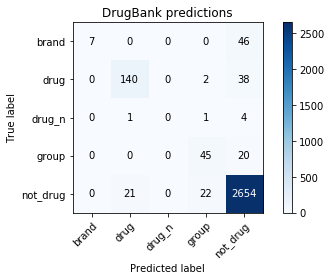

In [39]:
class_names = le.classes_
plot_confusion_matrix(Y_test_drugbank_enc, Y_pred_drugbank, classes=class_names, title="DrugBank predictions")
plt.show()

Confusion matrix, without normalization


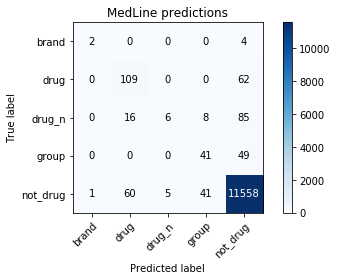

In [40]:
class_names = le.classes_
plot_confusion_matrix(Y_test_medline_enc, Y_pred_medline, classes=class_names, title="MedLine predictions")
plt.show()

## Detection and classification

In [41]:
def parsed_sentence_to_df(parsed):
    items = []
    for tree in parsed:
        for s in tree.getElementsByTagName("sentence"):
            s_id = s.attributes["id"].value
            s_txt = s.attributes["text"].value            
                
            tkns = nltk.word_tokenize(s_txt)
            start = 0
            for tkn in tkns:
                    start = s_txt.find(tkn, start) 
                    end = start + len(tkn) - 1
                    item = {"s_id": s_id, "e_name": tkn, "e_offset_start": start, "e_offset_end": end}
                    items.append(item)
                    start += len(tkn)
                
    return pd.DataFrame(items)

def load_unlabeled_data(datadir):
    trees = parse_XML_file(datadir)
    df_loaded = parsed_sentence_to_df(trees)
    return df_loaded

In [43]:
data_drugbank = load_unlabeled_data(dir_test_drugbank)
extract_features(data_drugbank)
data_drugbank.head()

,e_name,e_offset,s_id,e_is_title,e_is_upper,e_suffix,e_plural,e_pos,e_is_digit
0,There,0-4,DDI-DrugBank.d683.s0,True,False,There,False,EX,False
1,are,6-8,DDI-DrugBank.d683.s0,False,False,are,False,VBP,False
2,",",9-9,DDI-DrugBank.d683.s0,False,False,",",False,",",False
3,as,11-12,DDI-DrugBank.d683.s0,False,False,as,True,IN,False
4,yet,14-16,DDI-DrugBank.d683.s0,False,False,yet,False,RB,False


In [44]:
data_medline = load_unlabeled_data(dir_test_medline)
extract_features(data_medline)
data_medline.head()

,e_name,e_offset,s_id,e_is_title,e_is_upper,e_suffix,e_plural,e_pos,e_is_digit
0,Potential,0-8,DDI-MedLine.d203.s0,True,False,ntial,False,JJ,False
1,underuse,10-17,DDI-MedLine.d203.s0,False,False,eruse,False,NN,False
2,",",18-18,DDI-MedLine.d203.s0,False,False,",",False,",",False
3,overuse,20-26,DDI-MedLine.d203.s0,False,False,eruse,False,NN,False
4,",",18-18,DDI-MedLine.d203.s0,False,False,",",False,",",False


In [47]:
def save_output(data_df, file_name):
    with open(file_name, "w") as text_file:
        for index, row in data_df.iterrows():
            X = np.array(row[3:])
            encoded = enc.transform([X])
            prediction = clf.predict(encoded)
            label = le.inverse_transform(prediction)[0]
            if label != "not_drug":
                print(row["s_id"], row["e_offset"], row["e_name"], label, sep="|", file=text_file)

In [48]:
save_output(data_medline, "task9.1_TREE1_medline_2.txt")
save_output(data_drugbank, "task9.1_TREE1_drugbank_2.txt")